# Machine learning в продакшне

Поговорим, от том, как выводить модели в продакшн. Вы уже знакомы с понятием "жизненный цикл ML проекта" - сегодня мы увидим, как этот цикл выглядит в реальной жизни и попробуем вывести в продакшн модель классификации с помощью технологии виртуализации Docker (можно и без docker)

In [2]:
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)[:5]))

Содержимое директории /opt/ml/data: ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


В этом уроке мы поговорим о том, как обосновать перед бизнесом необходимость внедрения новой ML-системы

## Оффлайн эксперимент. Proof concept

В рамках курса вы
* узнали про огромное количество моделей: классификация, регрессия
* научились оценивать качество моделей
* можете готовить данные для алгоритмов, включая генерацию фичей

Однако, бизнесу не интересны задачи классификации или регрессии - бизнесу интересно зарабатывать деньги. Чтобы заработать деньги с помощью ML нужно найти конкретную бизнес-проблему, поиском проблем в бизнесе должен заниматься владелец бизнеса (в методологии Agile его зовут Product Owner) и понять, как эту бизнес-проблему можно решить. После такого  начального этапа выявления проблемы бизнес-хотелка отдаётся ML-специалисту, который должен создать инженерное решение для проблемы и интергрировать его в продакшн - после выкатывания прототипа "в прод" бизнес начинает зарабатывать миллионы и все счастливы.

Ниже я приведу полный путь от бизнес-идеи до прототипа - такой путь проходит любой проект ML, а называют такой пайплайн Proof of concept:

1. Перейти от общих слов продукт оунера к конкретным бизнес-требованиям. Желательно, чтобы DS проводил её сам (возможно привлечь бизнес-аналитика).
1. Описать дизайн (схему) эксперимента. Нужно понять, как повлиять на бизнес-метрики из первого пункта. На этом этапе нужно понять, какая информация доступна на входе, что ожидается на выходе и к какой задаче ML это можно свести  какие метрики покажут успешность задачи
1. Разобраться с данными: где храняться достаточно ли их для проверки гипотезы. Неплохо бы сразу осознать, будут ли данные в продакшене отличаться от того, что доступно в трейне.
1. Наинженерить фич и построить модель
1. Оценить качество модели, посчитать технические и бизнесовые метрики (см. третий урок)
1. Оценить ROI (Return on Investment) — ради этого всё и затевается.

Фишка этих шагов в том, что ошибка на любом шаге сильно ухудшает весь проект - например, плохая постановка бизнес-требований приведёт к провальному эксперименту.

Расчёт ROI - самый важный, финальный этап. Без расчёта эффективности бизнес-заказчик не даст вам добра на выкатывание в продакшн.

ROI  — это показатель доходности проекта, равный отношению доходов к затраченным инвестициям. ROI < 100% означает, что проект не окупится.

`ROI` = (`LTP`)/(`CL` + `LTL`)

1. LTP(Lifetime Profit)  - сколько доходов принесёт проект, пока его не свернут. Вычисляется как *операционные доходы* $\times$ *срок жизни*
1. CL (Capital Loss) - затраты на старт проекта
1. LTL(Lifetime Loss)  - сколько расходов принесёт проект, пока его не свернут. Вычисляется как *операционные расходы проекта* $\times$ *срок жизни проекта*

В капитальные затраты входит закупка железа и лицензий, разработку системы и ее внедрение. Операционные расходы - это то, что тратится на поддержание сервиса: зарплата программистов, devops-инженеров, аренда серверов.

Из-за "мгновенных" капитальных расходов на старте проекта ROI будет зависеть от времени, на котором мы оцениваем доходность. Обычно для расчета ROI используется или год - нужно понять, окупится проект за год или нет.


На далеком горизонте планирования можно окупить любую систему, поэтому важно понять величину *Lifetime* - сколько проработает система

В этом уроке мы узнали, что такое Proof of concept: какие действия нужно произвести чтобы понять, что модель будет полезна и принесёт выгоду. В следующем уроке мы поговорим о метриках сервиса - как понять, что модель действительно работает

## Метрики моделей ML

Метрики ML-сервисов (как и любых других продакшн-систем) можено разделить на три основных группы

* оффлайн-метрики модели
* технические метрики сервиса
* продуктовые (бизнес) метрики


### Оффлайн метрики

Оффлайн-метрики показывают, насколько хорошо алгоритм "выучил" исторические данные. С этими метриками вы сталкивались в течение всего курса:

* RMSE
* MAE
* precision
* recall
* accuracy
* MAP
* $\ldots$

Эти метрики не могут сказать, что модель будет достаточно хороша для бизнеса, но такая модель, как минимум, будет "не совсем плоха" чтобы отказываться от её выкатывания в прод. То есть выкатывают модель с хорошими оффлайн метриками и надеются, что она улучшит онлайн-метрики (см. дальше)

В реальной жизни обучение модели запускается регулярно, поэтому оффлайн-метрики нуждаются в мониторинге.

Пример из боевой системы обучения моделей: если ROC-AUC падает ниже 0.8, то модель в продакшн не выкатывается, а разработчику приходит уведомление в slack: дружище, с твоей моделью что-то не так, посмотри что случилось:

```shell
12:11:52,344 | INFO     | hydramatrices_data.py    :65   | Данные из HDFS загружены
12:12:10,651 | INFO     | learn2rank_model.py      :168  | Разбили данные на train и test
12:13:15,113 | INFO     | learn2rank_model.py      :248  | Кол-во объектов в train 1643676
12:14:24,329 | INFO     | learn2rank_model.py      :265  | Новая модель Learning to Rank c2c готова
12:14:49,295 | INFO     | learn2rank_model.py      :268  | Train Area under ROC = 0.8517
12:15:11,057 | INFO     | learn2rank_model.py      :272  | Test Area under ROC = 0.8516
```

### Технические метрики

Технические метрики сервиса - это некоторые показатели "здоровья", железа, которые никак не связаны с логикой

* `RPS` (response per second) - сколько запросов в секунду прилетает на сервис
* `response time` - время ответа сервиса
* `CPU idle` - "бездействие системы", чем больше тем лучше. Если падает idle - значит, сильно загружен процессор
* `available memory` - сколько памяти доступно на серверах
* `500 errors` - количество 500-х ошибок на сервисе

Дэшборды с техническими метриками могут выглядеть как-то так:

![tech_metrics](img/tech_metrics.png)

Для сбора и визуализации технических метрик используются следующие инструменты, которые должен знать каждый ML специалист:

* statsd - хранение метрик
* Grafana - визуализиция графиков
* Zabbix - визуализация и отправка уведомлений (например, в slack)
* Sentry - для анализа 500-х ошибок
* Kibana - логи сервиса

Прежде чем катить модель в прод нужно ознакомиться с каждым из этих инструментов и интегрировать с ними свою модель.

### Продуктовые метрики

Продуктовые метрики это то, что в первую очередь интересует бизнес. Когда выкатываете новую модель - она должна делать бизнесу лучше, а делать ML ради ML точно не стоит

Какие метрики можно улучшить с помощью ML

* средний чек
* retention - возвращаемость клиентов на сервис
* churn - отток клиентов с сервиса
* bounce - % пользователей, которые зашли на сервис, но ничего не сделали  (показатель отказов)
* конверсия в покупку

Проверять, что ваша модель улучшает метрики следует с помощью АБ-теста

![ab_testing](img/ab_testing.png)

В этом уроке мы узнали, как следить за моделями в продакшн. Вы познакомились с понятием "технические метрики сервиса" и теперь знаете, как сделать из "чёрного ящика" вашей модели прозрачный и управляемый сервис

В следующем уроке мы перейдём к самому интересному - поговорим, как разворачивать модели на боевых серверах

## Деплой модели: Docker

Этапы разработки прод-сервиса:
* разведочный анализ данных
* прототип модели в Jupyter
* продакшн-сервис

Как же перейти от любимого Jupyter ноутбука к продакшин сервису? Современные архитектуры web-проектов предполагают т.н. микросервисную архитектуру, когда для решения конкретной бизнес задачи поднимается маленький веб-сервис, который умеет принимать http-запросы и делать predict, возвращая предсказания в виде json-объекта.

JSON - это стадартный формат для общения микросервисов друг с другом, о нём говорили в самом начале курса

![microservices-logical.png](img/microservices-logical.png)

Как упаковать модель в микросервис? Для этого питоновский код нужно обернуть в http-сервер, который будет "сёрвить" (обслуживать) http-запросы. Вариантов http-сервера очень много

* [Flask](https://palletsprojects.com/p/flask/)
* [aiohttp](https://aiohttp.readthedocs.io/en/stable/)
* [http.server](https://docs.python.org/3/library/http.server.html)

Такой сервис обычно имеет url, на который можно отправлять запросы в заранее определённом формате, например `https://you.service/classify?uid=999` и возвращать ответ в JSON `{'uid': 999, 'class': 1}`

При чём тут **Docker**? Докер - это система виртуализации, которая позволяет унифицировать среду разработки и среду выполнения приложения: вы пишете код, который исполняется в виртуальной машине, тестируете его - а потом на боевые сервера отправляется та же самая виртуальная машина.

Получается, что вам не нужно волноваться о том, как будет жить питоновский код в продакшне - потому что будет исполняться в той же среде, в которой вы его разрабатывали (и тестировали). Докер является де-факто стандартом в мире современных архитектур для деплоя (т.е. вывода в продакшн-среду) моделей ML.

### Простой докер-контейнер

Вы уже пользовались докером для разворачивания Postgres базы данных, но не писали своих докерфайлов. Давайте исправим этот факт и напишем простой докер-сервис!

Алгоритм упаковки сервиса в докер следующий

1. Выбрать базовый образ. Я выбрал образ `python:3.12`
1. Чтобы докер делал что-то полезное, нужно запустить внутри него программу. Программы внутри контейнера принято запускать через файл `docker-entrypoint.sh`. Для примера я создал файл [simple-entrypoint.sh](dockerfiles/api/docker-entrypoint.sh), внутри которого три сценария работы контейнера
1. Чтобы собрать контейнер, нужно описать его структуру в Dockerfile. Загляните в файл [api/Dockerfile](dockerfiles/api/Dockerfile), где описана структура нашего контейнера

Находясь в корневой директории надо запустить сборку контейнера командой
```shell
make build-api 
```

После окончания процесса сборки запустить контейнер с помощью инструкции `docker run`:
```shell
docker run api:latest hello
```

В результате должны увидеть в консоли `Hello, engineer!`.

В этом уроке мы создали простой контейнер (для понимания), который только и умеет что выводить на печать простую фразу. В следующем уроке мы упакуем в докер пайплайн для тренировки и развёртывания модели машинного обучения в виде http-сервиса.

# Упаковка модели в Docker: этап research

Перед тем, как погружаться в мир докера, создадии пайплайн обучения на python.

Начнём с загрузки данных

In [7]:
import pandas as pd
import numpy as np

df_source = pd.read_csv(os.path.join(root_data_dir, 'client_segmentation.csv'))
X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

df_source.head(3)

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0.0
1,-0.889273,-0.537896,-1.959469,2.0
2,-0.841503,0.846665,0.727606,0.0


Это датасет, в котором три фичи `call_diff`, `sms_diff` и `traffic_diff` которые отражают относительное изменение в объёме звонков, смс и интернет-трафика соответственно по абонентам в базе телеком-оператора и несколько классов клиентов:

* класс `0` - пользователь платит много
* класс `1` - пользователь платит мало
* класс `2` - пользователь ушёл в отток (не платит ничего)

От нас требуется обучить модель классификации на три класса.

Для визуализации данных выполним понижение размерности с помощью *t-sne*

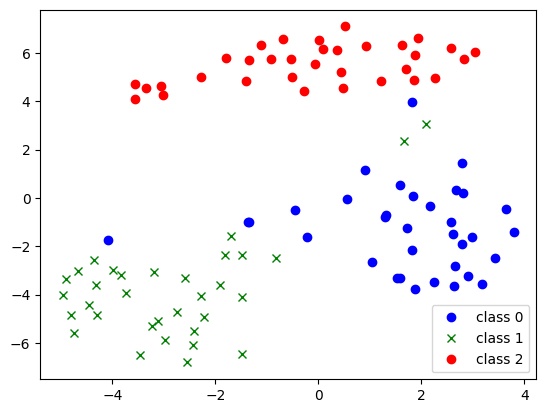

In [8]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

x_tsne = TSNE(n_components=2).fit_transform(X)
colors = ['bo', 'gx', 'ro']; num_labels = len(colors)
# И нарисуем получившиеся точки в нашем новом пространстве
for name, label, color in [('class_%d' % i, i, colors[i]) for i in range(num_labels)]:
    plt.plot(x_tsne[y == label, 0], x_tsne[y == label, 1], color, label="class %d" % label)
plt.legend(loc=0); plt.show()

Бизнесу требуется построить классификатор клиентов - давайте обучим простенький классификатор, основанный на решающем дереве.

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# выбираем рандомный объект

num_objects = X.shape[0]
random_id = np.random.randint(num_objects)

# преобразуем фичи, чтобы подошли на вход модели и делаем предсказания
test_object = X[random_id,:].reshape(1, -1)
pred = clf.predict(test_object)
print(f"У объекта под номером {random_id} класс {pred[0]}")

У объекта под номером 43 класс 0.0


Гототово, у нас есть модель, которая что-то обучает и что-то предсказывает. Можем сериализовать её для дальнейшего использования c помощью `pickle`. А теперь попробуем обернуть в докер наш пайплан обучения модели.

Запуск обучения модели - см. файл `dockerfiles/api/src/train.py`
```shell
make run-train
```

Вся полезная информация отправляется в файл с логами
```shell
tail -n1 data/pipelines-data/service.log
```

Пример логов модели
```shell
2020-04-24 06:55:54,070 | INFO     | service.py               :70   | Загружаем обученную модель
2020-04-24 06:55:54,071 | INFO     | service.py               :73   | Модель загружена: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

```

Запуск микросервиса - см. в файле `dockerfiles/api/src/main.py`
```shell
make run-service
```

Увидеть запущенный контейнер можно через Docker ps
```shell
docker ps
```

Результат команды
```shell
CONTAINER ID        IMAGE                     COMMAND                  CREATED             STATUS              PORTS                    NAMES
c9ba7303712c        mai:advanced   "docker-entrypoint.s…"   14 hours ago        Up 14 hours         0.0.0.0:5000->5000/tcp   infallible_easley
```

Чтобы проверить, что сервис "жив" и способен принимать запросы откройте в браузере спициальную страничку `http://0.0.0.0:8002/ping` - это т.н. *healh check* нашего сервиса. В браузере должно появится

```json
{"message": "pong"}
```

Хороший туториал по [упаковке моделей в контейнеры](https://towardsdatascience.com/deploying-machine-learning-models-with-docker-5d22a4dacb5). Там можно почитать, как скейлить нагрузку помощью nginx+gunikorn

В нашем датасете три фичи - нам нужно передать их в наш микросервис. Передавать фичи можно через GET-запросы, например, так:
```url
http://0.0.0.0:8002/classifier/?x1=1&x2=-2.2&x3=1.05
```

Дальше нам нужно перехватить их на стороне сервиса, обработать фичи, загрузив в классификатор и выдать ответ:
```json
{"x1": 1.0, "x2": -2.2, "x3": 1.05, "predicted_class": 0}
```

После окончания работ контейнер можно остановить
```shell
docker stop c9ba7303712c
```

Мы упаковали модель в докер и можем использовать модель как микросервис - отправлять запросы и получать предсказания

Давайте обобщим все наши знания о микросервисах в одной картинке

* у микросервиса должен быть определён формат ответа в виде JSON схемы
* Consul - это сервис, который автоматически дёргает *health check* и рестартует контейнер, если он перестал отвечать
* блок `logs` - это Elastic+Logstash+Kibana, связка используется для хранения логов
* технические метрики отправляются в хранилище Prometheus и визуализируются  в Grafana. Нотификации в случае нештатных ситуаций отправляются в Slack
* инциденты в виде 500-х ошибок отправляются в Sentry для дальнейшего анализа

![microservice.png](img/microservice.png)

# User interface

Для демки сервиса я использую streamlit

```
make run-streamlit
```

Откроется в localhost